# Capstone Project, Claire Lubash #
## Divvy Bike Data - Predictive Modeling ##
The goal of this project is to utilize the data provided by Divvy Bikes, and then build a model which predicts how long a trip will taken, given a starting and ending destination. Our data involves bike trips taken in Chicago during 2017 and includes these variables:
- trip_id
- start_time
- stop_time
- bikeid
- tripduration
- from_station_name
- to_station_name
- usertype
- gender
- birthyear
- latitude and longitude for stations

With these parameters, along with additional external data such as traffic and weather patterns, we are able to clean, visualize, and analyze the data set. Finally, we can build and improve upon a model for predicting trip durations. 

## I. Data Preparation & Cleaning
- Import the necessary packages and the .csv files provided by Divvy Bike 
- The files are then merged into one large data frame, which contains the data for all the trips as well as all the stations
- Remove redundant columns and clean up headers
- Calculate distance and speed, and add to data frame
- Change gender and to dummy variable
- Change columns to correct data types

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import datetime
from datetime import date
from math import sin, cos, sqrt, atan2, radians
from bokeh.plotting import figure, show, output_notebook
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import mean_squared_error, r2_score
from wwo_hist import retrieve_hist_data
import folium
%matplotlib inline

In [2]:
df1 = pd.read_csv('tripq1.csv')
df2 = pd.read_csv('tripq2.csv')
df3 = pd.read_csv('tripq3.csv')
df4 = pd.read_csv('tripq4.csv')

dfStat12 = pd.read_csv('stationq1q2.csv')
dfStat34 = pd.read_csv('stationq3q4.csv')

In [3]:
%%capture
df = pd.concat([df1, df2, df3, df4])
dfStat = pd.concat([dfStat12,dfStat34],sort=False).drop_duplicates().reset_index(drop=True)
dfStat = dfStat.drop(['name','city','dpcapacity','online_date','Unnamed: 7'],axis=1)

In [4]:
dfFrom = df.merge(dfStat, left_on = 'from_station_id', right_on = 'id')

In [5]:
dfFrom.drop_duplicates(subset = 'trip_id', keep = 'first', inplace = True) 

In [6]:
dfFrom = pd.merge(df, dfStat, left_on = 'from_station_id', right_on = 'id')
dfTo = pd.merge(df, dfStat, left_on = 'to_station_id', right_on = 'id')

In [7]:
dfFrom = dfFrom.rename(columns = {'latitude':'start_lat', 'longitude':'start_long'}) 
dfTo = dfTo.rename(columns = {'latitude':'end_lat', 'longitude':'end_long'})

In [8]:
dfFinal = pd.merge(dfFrom, dfTo, on = 'trip_id')

In [9]:
dfFinal.drop_duplicates(subset = 'trip_id', keep = 'first', inplace = True)

In [10]:
## remove redundant columns

dfFinal = dfFinal.drop(['start_time_y','end_time_y','bikeid_y','tripduration_y','from_station_id_y',
                        'from_station_name_y','to_station_id_y','to_station_name_y','usertype_y','birthyear_y',
                        'gender_y','id_y','id_x'], axis = 1)
dfFinal = dfFinal.rename(columns = {'start_time_x':'start_time','end_time_x':'end_time','bikeid_x':'bike_id',
                                    'tripduration_x':'trip_duration','from_station_id_x':'from_station_id',
                                    'from_station_name_x':'from_station_name','to_station_id_x':'to_station_id',
                                    'to_station_name_x':'to_station_name','usertype_x':'user_type',
                                    'gender_x':'gender','birthyear_x':'birth_year'})

In [11]:
## calculate distance

def dist(sla,ela,slo,elo):
    
    ''' 
    take in start/end coordinates
    implement Haversine formula
    return distance in miles
    '''
    
    lat1 = radians(sla)
    lat2 = radians(ela)
    long1 = radians(slo)
    long2 = radians(elo)
    lat = lat2 - lat1
    long = long2 - long1
    
    a = sin(lat / 2)**2 + cos(lat1) * cos(lat2) * sin(long / 2)**2
    c = (6373*(2 * atan2(sqrt(a), sqrt(1 - a))))*0.621371
    
    return(c)

In [12]:
dfFinal['distance'] = dfFinal.apply(lambda x: dist(x.start_lat,x.end_lat,x.start_long,x.end_long), axis = 1)
dfFinal['speed'] = dfFinal.distance/(dfFinal.trip_duration/60)

In [13]:
## dummy variable for gender

dfFinal.gender = dfFinal.gender.fillna(0)
dfFinal.gender[dfFinal.gender == 'Male'] = 1
dfFinal.gender[dfFinal.gender == 'Female'] = 2

## getting correct data types

dfFinal.gender = dfFinal.gender.astype(float)
dfFinal.trip_id = dfFinal.trip_id.astype(float)
dfFinal.bike_id = dfFinal.bike_id.astype(float)
dfFinal.trip_duration = dfFinal.trip_duration.astype(float)
dfFinal.from_station_id = dfFinal.from_station_id.astype(float)
dfFinal.to_station_id = dfFinal.to_station_id.astype(float)

/Users/claire.lubash@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/claire.lubash@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
dfFinal['start_time'] = pd.to_datetime(dfFinal['start_time'])

In [15]:
dfFinal['end_time'] = pd.to_datetime(dfFinal['end_time'])

### Adding External Data Sources

- Introduce a column to determine whether the trip was taken during rush hour 
    - Weekdays 7-9:59am, 4-6:59pm 
- Add in weather data using WorldWeatherOnline historical weather data API wrapper
    - Drop irrelevant columns
    - Change to correct data types
- Merge weather data with current data frame

In [13]:
## add rush hour column

dfFinal['rush'] = np.where(((dfFinal['start_time'].dt.weekday < 5) & (dfFinal['start_time'].dt.hour > 16) & (dfFinal['start_time'].dt.hour < 19)) | ((dfFinal['start_time'].dt.weekday < 5) & (dfFinal['start_time'].dt.hour > 7) & (dfFinal['start_time'].dt.hour < 10)), '1', '0')


In [14]:
### wwo-hist api

frequency = 24
start_date = '01-JAN-2017'
end_date = '31-DEC-2017'
api_key = '3abb4c87bb0b44b6894181920192908'
location_list = ['Chicago']

hist_weather_data = retrieve_hist_data(api_key, location_list, start_date, end_date, frequency, location_label = False, export_csv = True, store_df = True)



Retrieving weather data for Chicago


Currently retrieving data for Chicago: from 2017-01-01 to 2017-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.722836
Currently retrieving data for Chicago: from 2017-02-01 to 2017-02-28
Time elapsed (hh:mm:ss.ms) 0:00:01.360071
Currently retrieving data for Chicago: from 2017-03-01 to 2017-03-31
Time elapsed (hh:mm:ss.ms) 0:00:02.090463
Currently retrieving data for Chicago: from 2017-04-01 to 2017-04-30
Time elapsed (hh:mm:ss.ms) 0:00:02.788316
Currently retrieving data for Chicago: from 2017-05-01 to 2017-05-31
Time elapsed (hh:mm:ss.ms) 0:00:03.517786
Currently retrieving data for Chicago: from 2017-06-01 to 2017-06-30
Time elapsed (hh:mm:ss.ms) 0:00:04.190978
Currently retrieving data for Chicago: from 2017-07-01 to 2017-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.976326
Currently retrieving data for Chicago: from 2017-08-01 to 2017-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.618922
Currently retrieving data for Chicago: from 2017-09-01 to 2017-09-30
Tim

In [15]:
dfW = pd.read_csv('Chicago.csv')
dfW.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2017-01-01,3,-3,0.0,8.7,2,2,20,10:23 AM,09:09 PM,...,-4,17,14,67,0.0,1020,3,10,191,12
1,2017-01-02,3,1,0.0,3.4,1,1,27,10:59 AM,10:12 PM,...,-1,22,75,92,3.1,1019,3,8,96,13
2,2017-01-03,4,0,0.0,3.4,1,1,34,11:33 AM,11:17 PM,...,-1,24,99,92,0.6,1010,4,4,175,17
3,2017-01-04,-6,-10,0.0,8.7,2,2,41,12:05 PM,No moonset,...,-17,37,16,63,0.0,1018,-6,10,285,32
4,2017-01-05,-10,-13,0.1,5.2,1,1,49,12:38 PM,12:23 AM,...,-20,26,87,64,0.1,1020,-10,10,286,22


In [16]:
dfW.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'uvIndex.1', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [19]:
## drop unneeded columns

# dfW = dfW.drop(['moonrise','moonset','winddirDegree','moon_illumination','sunHour','uvIndex','uvIndex.1','maxtempC','mintempC','sunrise','sunset','DewPointC','FeelsLikeC','HeatIndexC','WindChillC','WindGustKmph','pressure','windspeedKmph'],axis=1)
dfW = dfW.drop(['moonrise', 'moonset', 'uvIndex.1', 'moon_illumination', 'winddirDegree', 'WindGustKmph', 'DewPointC', 'maxtempC', 'mintempC', 'sunrise', 'sunset'], axis = 1)

## correct data types

dfFinal['start_date'] = dfFinal['start_time'].dt.date
dfFinal['start_date'] = pd.to_datetime(dfFinal['start_date'])
dfW['date_time'] = pd.to_datetime(dfW['date_time'])

## calculate age column

dfFinal['age'] = datetime.datetime.now().year - dfFinal.birth_year

In [20]:
dfFinal = pd.merge(dfFinal, dfW, left_on = 'start_date', right_on = 'date_time')

### Additional Cleaning on Merged Data
- Remove outliers
    - No points outside +/- 2 standard deviations from the mean
    - Round up for some cushion
- Remove round trips (distance = 0)

In [21]:
pd.options.display.float_format = '{:.2f}'.format
dfFinal.describe()

,trip_id,bike_id,trip_duration,from_station_id,to_station_id,gender,birth_year,start_lat,start_long,end_lat,...,FeelsLikeC,HeatIndexC,WindChillC,cloudcover,humidity,precipMM,pressure,tempC,visibility,windspeedKmph
count,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,12434727.00,15807082.00,15807082.00,15807082.00,...,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00,15807082.00
mean,15340605.23,3434.79,946.51,180.27,180.41,0.98,1981.55,41.90,-87.64,41.90,...,14.82,16.27,14.41,32.25,71.38,2.47,1015.72,18.16,9.65,15.83
std,1338075.39,1865.89,1558.19,132.53,132.66,0.64,10.89,0.04,0.02,0.04,...,10.52,8.94,10.09,25.21,11.31,5.32,6.02,8.54,0.79,6.05
min,12979230.00,1.00,60.00,2.00,2.00,0.00,1899.00,41.74,-87.80,41.74,...,-24.00,-15.00,-24.00,0.00,37.00,0.00,998.00,-14.00,4.00,5.00
25%,14196561.00,1810.00,399.00,74.00,74.00,1.00,1976.00,41.88,-87.65,41.88,...,7.00,9.00,7.00,13.00,62.00,0.00,1012.00,12.00,10.00,11.00
50%,15346584.00,3592.00,679.00,156.00,156.00,1.00,1985.00,41.89,-87.64,41.89,...,18.00,19.00,18.00,23.00,72.00,0.20,1016.00,21.00,10.00,14.00
75%,16504182.75,5079.00,1138.00,268.00,268.00,1.00,1990.00,41.92,-87.63,41.92,...,22.00,23.00,22.00,44.00,79.00,2.60,1019.00,25.00,10.00,20.00
max,17536701.00,6471.00,86338.00,626.00,626.00,2.00,2017.00,42.06,-87.55,42.06,...,30.00,30.00,27.00,100.00,97.00,40.10,1042.00,31.00,10.00,40.00


In [23]:
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['trip_duration'] > 5000)])
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['speed'] > 0.4)])
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['birth_year'] > 2000)])
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['birth_year'] < 1947)])
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['age'] > 60)])
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['age'] < 15)])

In [42]:
dfFinal = dfFinal.drop(dfFinal.index[(dfFinal['distance'] == 0)])

In [22]:
## calculate percentage of missing data

(dfFinal.isnull().sum() / len(dfFinal)).sort_values(ascending=False)

age                 0.21
birth_year          0.21
windspeedKmph       0.00
distance            0.00
end_lat             0.00
start_long          0.00
start_lat           0.00
gender              0.00
user_type           0.00
to_station_name     0.00
to_station_id       0.00
from_station_name   0.00
from_station_id     0.00
trip_duration       0.00
bike_id             0.00
end_time            0.00
start_time          0.00
end_long            0.00
speed               0.00
visibility          0.00
rush                0.00
start_date          0.00
date_time           0.00
totalSnow_cm        0.00
sunHour             0.00
uvIndex             0.00
FeelsLikeC          0.00
HeatIndexC          0.00
WindChillC          0.00
cloudcover          0.00
humidity            0.00
precipMM            0.00
pressure            0.00
tempC               0.00
trip_id             0.00
dtype: float64

## II. Data Visualizations

### 1. Top 5 Stations with Most Starts
We see that the most popular starting station is Streeter Drive & Grand Avenue, with ~341,000 starts during 2017. Below, is another visual which depicts the geographic locations of the top five most popular stations on a map of Chicago. 

In [23]:
counts = dfFinal['from_station_name'].value_counts()
counts = counts[:5,]

In [24]:
dfCounts = counts.to_frame('counts')

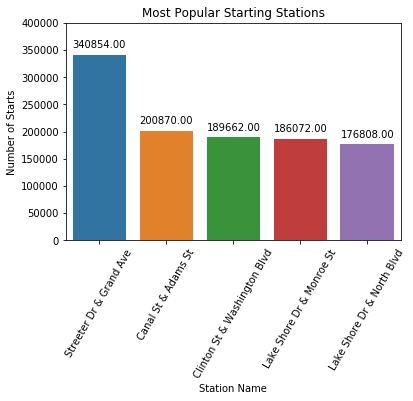

In [25]:
splot = sea.barplot(counts.index, counts.values)
plt.title('Most Popular Starting Stations')
plt.ylabel('Number of Starts')
plt.xlabel('Station Name')
plt.xticks(rotation=60)
plt.ylim(0, 400000)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [22]:
dfMap = dfFinal.loc[dfFinal['from_station_name'] == 'Streeter Dr & Grand Ave']
dfMap = dfFinal.loc[(dfFinal['from_station_name'] == 'Streeter Dr & Grand Ave') | (dfFinal['from_station_name'] == 'Clinton St & Washington Blvd') | (dfFinal['from_station_name'] == 'Canal St & Adams St') | (dfFinal['from_station_name'] == 'Lake Shore Dr & Monroe St') | (dfFinal['from_station_name'] == 'Lake Shore Dr & North Blvd')]
dfMap = dfMap.drop_duplicates('from_station_name')

In [23]:
m = folium.Map(location = [41.8781, -87.6298], zoom_start = 12)
for i in range(0,len(dfMap)):
    folium.Marker([dfMap.iloc[i]['start_lat'], dfMap.iloc[i]['start_long']], popup = dfMap.iloc[i]['from_station_name']).add_to(m)
m    

### 2.1 Average Trip Duration by User Type
We see that customers are taking longer trips on average than subscribers. The boxplot below also confirms that there is a larger distribution of trip lengths amongst customers, rather than subscribers. 

In [28]:
dfUser = dfFinal.groupby('user_type', as_index=False)['trip_duration'].mean()
dfUserMed = dfFinal.groupby('user_type', as_index=False)['trip_duration'].median()
dfUserSum = dfFinal.groupby('user_type', as_index=False)['trip_duration'].sum()
dfUserCount = dfFinal.groupby('user_type', as_index=False)['trip_duration'].count()
dfUserSum['trip_duration'] = dfUserSum['trip_duration']/3600

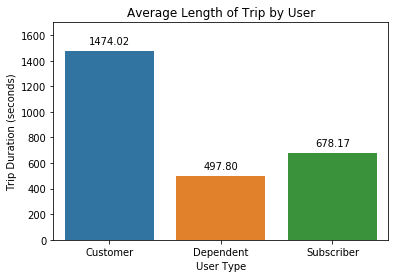

In [29]:
splot2 = sea.barplot(dfUser.user_type, dfUser.trip_duration)
plt.title('Average Length of Trip by User')
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('User Type')
for p in splot2.patches:
    splot2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,1700)
plt.show()

### 2.2 Median Trip Duration by User Type

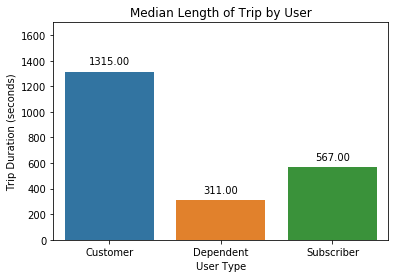

In [30]:
splot21 = sea.barplot(dfUserMed.user_type, dfUserMed.trip_duration)
plt.title('Median Length of Trip by User')
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('User Type')
for p in splot21.patches:
    splot21.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,1700)
plt.show()

### 2.3 Total Trip Hours by User Type

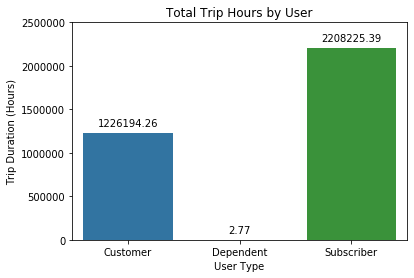

In [31]:
splotTrip = sea.barplot(dfUserSum.user_type, dfUserSum.trip_duration)
plt.title('Total Trip Hours by User')
plt.ylabel('Trip Duration (Hours)')
plt.xlabel('User Type')
for p in splotTrip.patches:
    splotTrip.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,2500000)
plt.show()

### 2.4 Total Trips by User Type

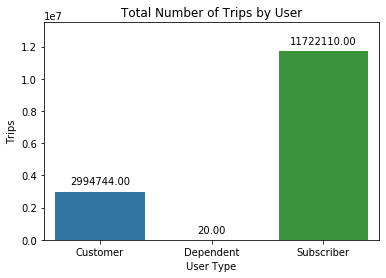

In [33]:
splotTrip = sea.barplot(dfUserCount.user_type, dfUserCount.trip_duration)
plt.title('Total Number of Trips by User')
plt.ylabel('Trips')
plt.xlabel('User Type')
for p in splotTrip.patches:
    splotTrip.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,13500000)
plt.show()

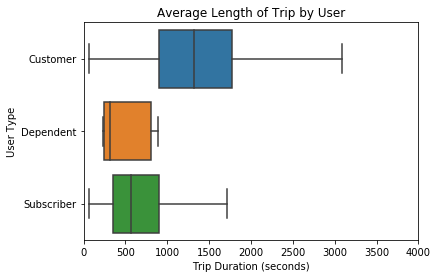

In [32]:
sea.boxplot(dfFinal.trip_duration, dfFinal.user_type, fliersize = 0, order = ['Customer','Dependent','Subscriber'])
plt.title('Average Length of Trip by User')
plt.ylabel('User Type')
plt.xlabel('Trip Duration (seconds)')
plt.xlim(0,4000)
plt.show()

### 3. Most Popular Trips
We see that the most popular trip is starting at Lake Shore Drive & Monroe Street and ending at Streeter Drive & Grand Avenue. 

In [95]:
dfTrips = dfFinal.groupby(['from_station_name','to_station_name']).size().reset_index(name = 'NumberOfTrips').sort_values('NumberOfTrips', ascending = False)

In [96]:
dfTrips.head()

,from_station_name,to_station_name,NumberOfTrips
49476,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,48040
85839,Streeter Dr & Grand Ave,Theater on the Lake,32612
85696,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,31748
49806,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,28700
85695,Streeter Dr & Grand Ave,Lake Shore Dr & Monroe St,28440


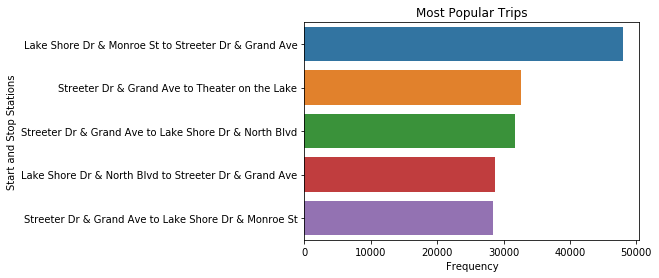

In [35]:
sea.barplot(dfTrips.NumberOfTrips[:5,],(dfTrips.from_station_name[:5,] + ' to ' + dfTrips.to_station_name[:5,]), orient='h')
plt.title('Most Popular Trips')
plt.ylabel('Start and Stop Stations')
plt.xlabel('Frequency')
plt.show()

### 4.1 Average Distance Traveled by Gender and Age 
We see that on average, men are traveling faster than women, but women are traveling longer distances. 

In [ ]:
## used to calculate speeds and distances for specific age and gender

now = dfFinal[(dfFinal['gender'] == 2) & (dfFinal['age'] >= 25) & (dfFinal['age'] < 35)]
print((now.speed.median())*60)
print(now.distance.mean())

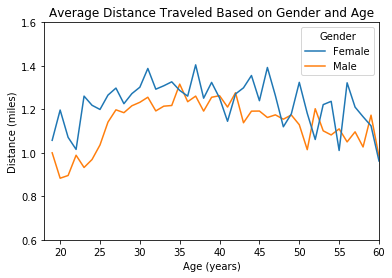

In [34]:
dfFinal.groupby(['age','gender']).mean()['distance'].unstack().plot(color = ('tab:blue', 'tab:orange', 'tab:blue'))
plt.xlim(10,80)
plt.title('Average Distance Traveled Based on Gender and Age')
plt.xlabel('Age (years)')
plt.ylabel('Distance (miles)')
plt.legend(['Female','Male'] , title = 'Gender')
plt.xlim(18,60)
plt.ylim(0.6,1.6)
plt.show()

### 4.2 Median Travel Speed by Gender and Age 

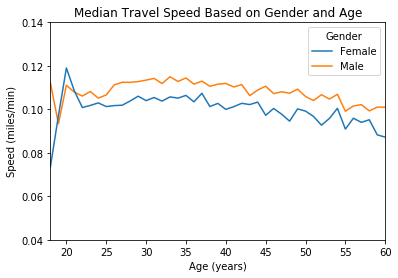

In [37]:
dfFinal.groupby(['age','gender']).median()['speed'].unstack().plot(color = ('tab:blue', 'tab:orange', 'tab:blue'))
plt.xlim(10,80)
plt.title('Median Travel Speed Based on Gender and Age')
plt.xlabel('Age (years)')
plt.ylabel('Speed (miles/min)')
plt.legend(['Female', 'Male'], title = 'Gender')
plt.xlim(18,60)
plt.ylim(0.04,0.14)
plt.show()

### 5.1 Busiest Bike by Number of Uses
Bike #2565 is the busiest bike in Chicago based on both number of uses and number of minutes.

In [38]:
dfBikeUse = dfFinal.groupby('bike_id').size().reset_index(name = 'TimesUsed').sort_values('TimesUsed', ascending = False)

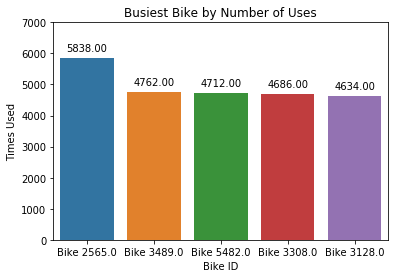

In [48]:
splot3 = sea.barplot(('Bike ' + dfBikeUse.bike_id[:5,].astype(str)), dfBikeUse.TimesUsed[:5,])
plt.title('Busiest Bike by Number of Uses')
plt.ylabel('Times Used')
plt.xlabel('Bike ID')
for p in splot3.patches:
    splot3.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,7000)
plt.show()

### 5.2 Busiest Bike by Number of Minutes

In [40]:
dfBikeMin = dfFinal.groupby('bike_id')['trip_duration'].sum().reset_index(name = 'minutes').sort_values('minutes', ascending = False)
dfBikeMin.minutes = round((dfBikeMin.minutes)/60,2)

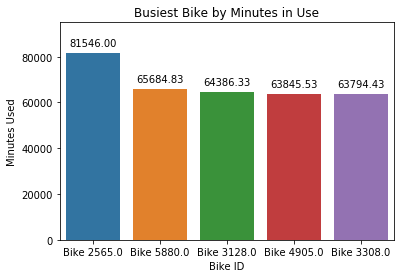

In [50]:
splot4 = sea.barplot(('Bike ' + dfBikeMin.bike_id[:5,].astype(str)), dfBikeMin.minutes[:5,])
plt.title('Busiest Bike by Minutes in Use')
plt.ylabel('Minutes Used')
plt.xlabel('Bike ID')
for p in splot4.patches:
    splot4.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0,95000)
plt.show()

## III. Model

### 1. Assumptions
We start by assuming some basic ideas to ensure the feasibility of our model. 
 1. When a passenger inputs a destination in the kiosk, we have access to their personal information (age, gender, user) either by manual input or an account registration. 
 2. The inputted destination is a known ending station. 
 3. The customer stays in the greater Chicago area. 

### 2. Baseline Model
- We begin with a simple approach for our base model, implementing an ordinary linear regression. 
- We once again clean up our data first, by dropping unneeded columns and converting user type to a dummy variable.
- We also had about 0.2% of our age data as missing, so we replace those null values with the mean of the inputted ages. 
- Then we split our data into training and testing data sets, with our target variable being trip_duration. 
- We fit the model and output the accuracy. 
    - Our model predicts with about 0.59 accuracy, so we will explore other options in order to imporve this score. 

In [26]:
## dropping irrelevant columns

dfModel = dfFinal.drop(['trip_id','bike_id','from_station_id','to_station_id','end_time','birth_year','start_lat','start_long','end_lat','end_long'],axis=1)
dfModel = dfModel.drop(['start_time','from_station_name','to_station_name','speed','start_date','date_time'], axis=1)
dfModel["age"].fillna(dfFinal.age.mean(), inplace = True)

In [27]:
## user type to dummy variable

dfModel.user_type[dfModel.user_type == 'Subscriber'] = 0
dfModel.user_type[dfModel.user_type == 'Customer'] = 1
dfModel.user_type[dfModel.user_type == 'Dependent'] = 2

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [30]:
dfModel.head()

,trip_duration,user_type,gender,distance,rush,age,totalSnow_cm,sunHour,uvIndex,FeelsLikeC,HeatIndexC,WindChillC,cloudcover,humidity,precipMM,pressure,tempC,visibility,windspeedKmph
0,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
1,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
2,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
3,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
4,128.00,0,1.00,0.33,0,35.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24


In [31]:
## split into training and testing

x = dfModel.iloc[:,1:11]
y = dfModel.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [43]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
print('\nAccuracy:', reg.score(x_test, y_test))
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))


Accuracy: 0.5865027462315744

Mean Absolute Error: 232.20723803460967


### 3. Second Model
- We can now explore another method of regression, Lasso Regression. 
- We fit the model and notice no improvement on the prediction. 

In [45]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train, y_train)
y_pred_lasso = clf.predict(x_test)

In [46]:
print('\nAccuracy:', clf.score(x_test, y_test))
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso))


Accuracy: 0.5864991637670534

Mean Absolute Error: 232.21640878535345


### 4. Feature Importance
- Since the previous models had much room for improvement, we will look into which features are most impactful on trip duration, and re-run our model while using only those variables. 
- The below visualiztion shows that distance, gender, temperature, and cloud cover have the most impact on trip duration. 

In [47]:
dfModel.corr().loc[:,'trip_duration']

trip_duration    1.00
gender          -0.36
distance         0.62
age             -0.00
totalSnow_cm    -0.04
sunHour          0.18
uvIndex          0.17
FeelsLikeC       0.17
HeatIndexC       0.17
WindChillC       0.17
cloudcover      -0.14
humidity         0.00
precipMM         0.00
pressure        -0.03
tempC            0.17
visibility       0.04
windspeedKmph   -0.08
Name: trip_duration, dtype: float64

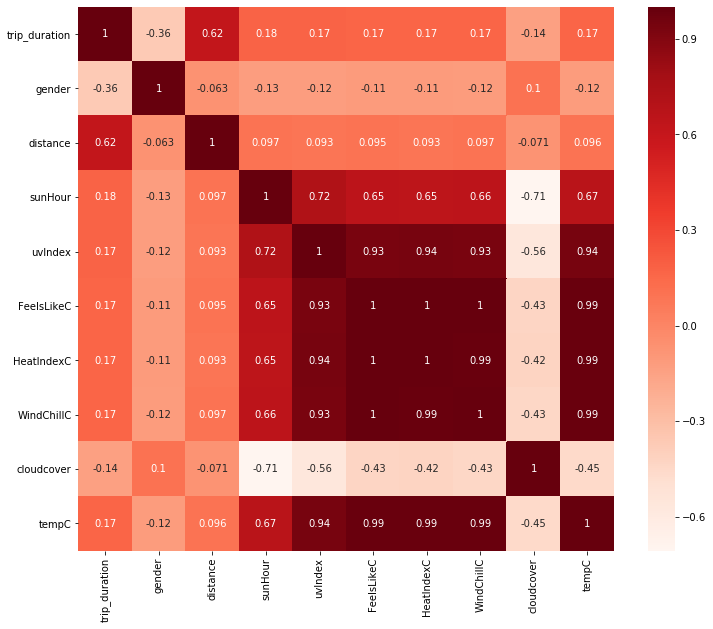

In [51]:
plt.figure(figsize=(12,10))
cor = dfModel[['trip_duration', 'gender', 'distance', 'sunHour', 'uvIndex', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'cloudcover', 'tempC']].corr()
sea.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [49]:
cor_target = abs(cor["trip_duration"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

trip_duration   1.00
gender          0.36
distance        0.62
sunHour         0.18
uvIndex         0.17
FeelsLikeC      0.17
HeatIndexC      0.17
WindChillC      0.17
cloudcover      0.14
tempC           0.17
Name: trip_duration, dtype: float64

In [52]:
dfModel.head()

,trip_duration,user_type,gender,distance,rush,age,totalSnow_cm,sunHour,uvIndex,FeelsLikeC,HeatIndexC,WindChillC,cloudcover,humidity,precipMM,pressure,tempC,visibility,windspeedKmph
0,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
1,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
2,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
3,857.00,0,1.00,2.20,0,30.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24
4,128.00,0,1.00,0.33,0,35.00,0.00,6.40,1,-2,3,-2,88,90,0.70,1010,3,9,24


### 5. Adjusted Linear Model
- We drop the variables that were not highlighted in the above analysis of feature importance. 
- We re-run our regression model. 
    - The model still shows no improvement.

In [54]:
dfAdj = dfModel.drop(['humidity', 'precipMM', 'age', 'totalSnow_cm', 'visibility', 'pressure', 'windspeedKmph'], axis = 1)

In [56]:
x2 = dfAdj.iloc[:,1:11]
y2 = dfAdj.iloc[:,0]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.2, random_state = 0)

In [57]:
regAdj = LinearRegression().fit(x_train2, y_train2)
print('\nAccuracy:', regAdj.score(x_test2, y_test2))


Accuracy: 0.5863265812257032


### 6. Further Analysis
- Since feature importance still did not improve the model, we investigate further into the data. 
- Distance was ranked as the most impactful feature on trip duration, so we plot distance vs. duration to see what the data looks like
    - We see an abnormally large amount of the data falls into the category of really short distance taking a really long time. This would be a strong reason why the models cannot reach a prediction accuracy above 60%. 
    - Unfortunately, there is way too much of this type of data to omit it entirely from the model. 

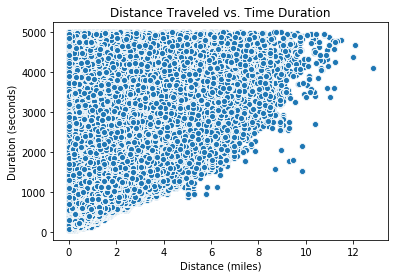

In [45]:
sea.scatterplot(x = "distance", y = "trip_duration", data = dfFinal)
plt.xlabel('Distance (miles)')
plt.ylabel('Duration (seconds)')
plt.title('Distance Traveled vs. Time Duration')
plt.show()